# Callin Switzer
### 16 March 2018
### Classify sequences to get buzz vs. no buzz

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it

In [2]:
def readMyFile(filename):
    
    '''Read in csv 10x faster than pandas'''
    
    tmpdta = []
 
    with open(filename, newline="\n") as csvDataFile:
        csvReader = csv.reader(csvDataFile, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
        for row in csvReader:
            tmpdta.append(row)
 
    return(pd.DataFrame(np.transpose(tmpdta)))

In [3]:
def windowsOrMacDirectories():
    """ Sets base directories for win or mac

       
    """
    if os.environ['COMPUTERNAME'] == 'SHEALMACLEARN':
        DropboxDirect = os.path.join("D:\Dropbox")
#     elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
#         # this excludes your current terminal "/dev/tty"
    elif sys.platform.startswith('darwin'):
        DropboxDirect = os.path.join("/Users/cswitzer/Dropbox")
    else:
        raise EnvironmentError('Unknown computer platform')
    
    baseDir = os.getcwd()
    dataDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehData')
    figDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehFigs')
    return baseDir, dataDir, figDir


baseDir, dataDir, figDir = windowsOrMacDirectories()
print(dataDir)

D:\Dropbox\SonicationBehavior\SonBehData


___
# Practice 
___

In [4]:
# read in dataset that was pre-classified
buzzClassDataDir = os.path.join("D:\Dropbox\SonicationBehavior\SonBehData\BuzzPartClassification")
buzzClass = pd.read_csv(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))
print(buzzClass.shape)
buzzClass.head()

(200, 7)


,fileName,noise1,noise2,wing1,wing2,buzz1,buzz2
0,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,10000,20000,0,10000
2,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
3,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,3000,10000,12500,20000
4,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000


In [5]:
# remove duplicated rows
buzzClass.drop_duplicates(subset = "fileName", inplace = True)
buzzClass.reset_index(drop = True, inplace = True)
buzzClass.shape

(194, 7)

In [6]:
buzzClass.head()

,fileName,noise1,noise2,wing1,wing2,buzz1,buzz2
0,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,10000,20000,0,10000
2,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
3,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,3000,10000,12500,20000
4,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000


In [7]:
ii = 10
tmp = readMyFile(buzzClass.fileName[ii])
pad = np.arange(tmp.iloc[-1,0],tmp.iloc[-1,0]+ 0.02-np.mean(np.diff(tmp.iloc[:,0])),  np.mean(np.diff(tmp.iloc[:,0])))
zx = np.repeat(0, len(pad))
pdff = pd.DataFrame( data = {"0":pad, "1":zx} )
pdff.columns = tmp.columns

tmp2 = pd.concat([tmp, pdff]).reset_index(drop = True)
tmp2.head()

,0,1
0,0.000000,-0.002323
1,0.000005,-0.002972
2,0.000010,-0.003946
3,0.000015,-0.002648
4,0.000020,-0.002972


In [8]:
# read in all data into a single dataframe
bigList = []
freqSpec = []
for ii in range(buzzClass.shape[0]):
    tmp = readMyFile(buzzClass.fileName[ii])
    
    # pad with 0's
    tmp = readMyFile(buzzClass.fileName[ii])
    pad = np.arange(tmp.iloc[-1,0],tmp.iloc[-1,0]+ 0.02 - np.mean(np.diff(tmp.iloc[:,0])),  np.mean(np.diff(tmp.iloc[:,0])))
    zx = np.repeat(0, len(pad))
    pdff = pd.DataFrame( data = {"0":pad, "1":zx} )
    pdff.columns = tmp.columns

    tmp = pd.concat([tmp, pdff]).reset_index(drop = True)
    
    # calculate rolling variance
    tmp["varia"] = pd.Series((tmp.iloc[:,1] - np.mean(tmp.iloc[:,1]))).rolling(int(2000), center = True, min_periods = 1).var().tolist()
    
    # calculate frequency spectrum
    f, t, Sxx = signal.spectrogram(tmp.iloc[:,1], 200000, noverlap = 900, nperseg = 1000)
    Sxx = Sxx[0:50, :]
    #scale
    Sxx = Sxx - np.min(Sxx)
    Sxx = Sxx / np.max(Sxx)
    
    
    
    freqSpec.append(pd.DataFrame(np.transpose(Sxx)))
    
    # add classes to data
    tmp["buzz"] = 0
    tmp.loc[buzzClass.buzz1[ii]:buzzClass.buzz2[ii], "buzz"] = 1
    if(np.mod(ii, 10)) == 0:
        print(ii)
    
    tmp["filename"] = buzzClass.fileName[ii]
    bigList.append(tmp)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


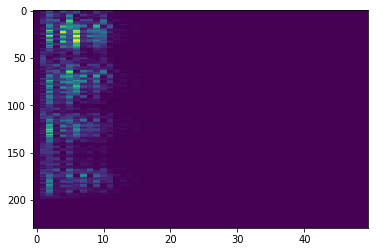

In [10]:
plt.imshow(np.transpose(Sxx - np.min(Sxx)), aspect = "auto")

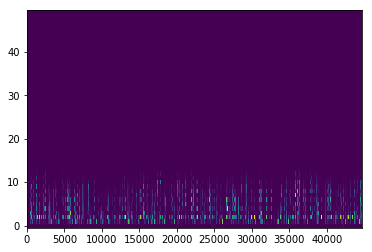

In [11]:
FS = pd.concat(freqSpec)
plt.imshow(FS.transpose(), aspect = "auto", origin = 'lower')

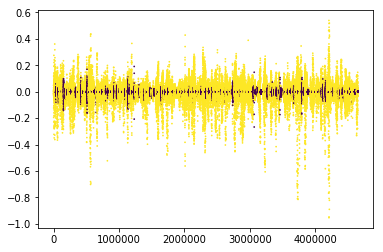

(4655806, 5)

In [12]:
df = pd.concat(bigList)
df.reset_index(drop = True, inplace = True)


subSamp = np.arange(0, df.shape[0], step = 50)
plt.scatter(df.index[subSamp], df.iloc[subSamp,1], s = 0.5, c = df.iloc[subSamp,3])
#plt.scatter(df.index[subSamp], df.iloc[subSamp,2]*10, s = 0.5, c = df.iloc[subSamp,3])
plt.show()
df.shape

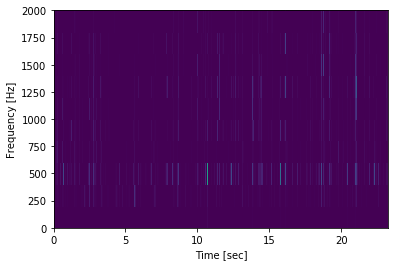

In [13]:
f, t, Sxx = signal.spectrogram(df.iloc[:,1], 200000, noverlap = 900, nperseg = 1000)
Sxx = Sxx[0:150, :]
f = f[0:150]
plt.pcolormesh(t, f, Sxx)
plt.ylim(0,2000)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [14]:
from skimage.transform import resize
#bb = resize(Sxx, output_shape = [20, df.shape[0]], order = 1, mode = 'reflect')
bb = resize(FS.transpose(), output_shape = [100, df.shape[0]], order = 1, mode = 'reflect')



In [15]:
cc = pd.DataFrame(np.transpose(bb))
dd = pd.concat([df,cc], axis = 1 )
dd.shape

(4655806, 105)

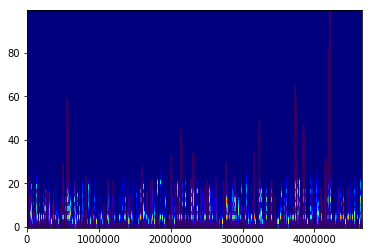

In [16]:
plt.set_cmap("jet")
plt.plot(df.loc[:,"varia"]* 1000, alpha = 0.2, c = 'red')
plt.imshow(bb, aspect = "auto", origin = 'lower')

In [17]:
# build test/train sets
np.random.seed(1235999)
trainSamps = np.random.choice(np.unique(dd.filename), 
                              size = int(0.75*len(np.unique(dd.filename))),
                             replace = False)



train = dd[dd['filename'].isin(trainSamps)]
train.reset_index(drop = True, inplace = True)

test = dd[~dd['filename'].isin(trainSamps)]
test.reset_index(drop = True, inplace = True)


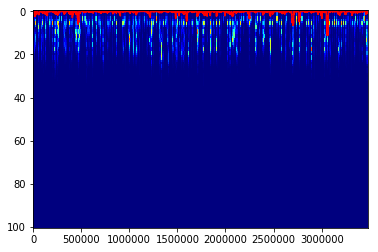

In [18]:
Ytrain= np.array(train["buzz"])
Xtrain = np.array(train.drop(["buzz", "filename"], axis = 1).iloc[:, 2:])

Ytest= np.array(test["buzz"])
Xtest = np.array(test.drop(["buzz", "filename"], axis = 1).iloc[:, 2:])


# scale each column -- save scaling factors
dfMin = Xtrain[:,1:].min(axis = 0)
dfMax =  Xtrain[:,1:].max(axis = 0)

varMin = Xtrain[:,0].min()
varMax =  Xtrain[:,0].max()

# Xtrain[:,1:] =  Xtrain[:,1:] - dfMin
# Xtrain[:,1:] =  Xtrain[:,1:] / dfMax
# Xtrain[:,0] =  Xtrain[:,0] - varMin
# Xtrain[:,0] =  Xtrain[:,0] / varMax

# Xtest[:,1:] =  Xtest[:,1:] - dfMin
# Xtest[:,1:] =  Xtest[:,1:] / dfMax
# Xtest[:,0] =  Xtest[:,0] - varMin
# Xtest[:,0] =  Xtest[:,0] / varMax

plt.imshow(np.array(np.transpose(Xtrain)), aspect='auto')

plt.plot(Xtrain[:,0]*100, c= 'red', markersize= 1000)

# plt.show()

# plt.plot(train.iloc[:,1])
# plt.plot(Xtrain[:,0]*5, c= 'red', markersize= 1000)


In [19]:
# support vector machine
from sklearn import svm
clf = svm.LinearSVC(dual = False)
clf.fit(Xtrain[:, 0:10], Ytrain)  
preds = clf.predict(Xtest[:, 0:10])
from sklearn.metrics import accuracy_score
print(accuracy_score(clf.predict(Xtrain[:, 0:10]), Ytrain))
accuracy_score(preds, Ytest)

0.8795544641946288


0.8461432491659941

In [20]:
# classify

from sklearn.ensemble import RandomForestClassifier as rfc

stt = time.time()
forest = rfc(n_jobs = -1)
forest.fit(Xtrain, Ytrain)
print(time.time() - stt)

47.323843002319336


In [21]:
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
preds = forest.predict(Xtest)
from sklearn.metrics import accuracy_score
print(accuracy_score(forest.predict(Xtrain), Ytrain))
accuracy_score(preds, Ytest)
accuracy_score(preds, Ytest)

0.999999425263409


0.9133450288319837

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [48]:
# Keras neural network classifier
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=Xtrain.shape[1], kernel_initializer='normal', activation='tanh'))
    model.add(Dense(30, activation = 'tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [38]:
def create_model(activation_function='relu', init_type='normal', optimiser='adam', dropout_rate=0.5):
    model = Sequential()
    # layer 1
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, kernel_initializer=init_type, activation=activation_function))
    # layer 2
    model.add(Dense(n_hidden_units_2, kernel_initializer=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, kernel_initializer=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(n_classes, kernel_initializer=init_type, activation='softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model


In [47]:
# neural network dimensions


n_dim = Xtrain.shape[1]
n_classes = 1
n_hidden_units_1 = n_dim
n_hidden_units_2 = int(n_dim * 2)
n_hidden_units_3 = int(n_hidden_units_2 / 2)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
model = create_model()
history = model.fit(Xtrain, Ytrain, batch_size = 100000, validation_split=0.25, verbose = 1, epochs  = 10, callbacks=[earlystop])

Train on 2609891 samples, validate on 869964 samples
Epoch 1/10
2609891/2609891 [==============================] - 9s 3us/step - loss: 6.4858 - acc: 0.5932 - val_loss: 6.5592 - val_acc: 0.5886
Epoch 2/10
2609891/2609891 [==============================] - 8s 3us/step - loss: 6.4858 - acc: 0.5932 - val_loss: 6.5592 - val_acc: 0.5886
Epoch 3/10
2609891/2609891 [==============================] - 8s 3us/step - loss: 6.4858 - acc: 0.5932 - val_loss: 6.5592 - val_acc: 0.5886
Epoch 4/10
2609891/2609891 [==============================] - 8s 3us/step - loss: 6.4858 - acc: 0.5932 - val_loss: 6.5592 - val_acc: 0.5886
Epoch 5/10
2609891/2609891 [==============================] - 8s 3us/step - loss: 6.4858 - acc: 0.5932 - val_loss: 6.5592 - val_acc: 0.5886
Epoch 6/10
2609891/2609891 [==============================] - 8s 3us/step - loss: 6.4858 - acc: 0.5932 - val_loss: 6.5592 - val_acc: 0.5886
Epoch 00006: early stopping


In [25]:
# estimator = KerasClassifier(build_fn=create_baseline, epochs=50, batch_size=10000, verbose=1)
# kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=123545)
# results = cross_val_score(estimator, Xtrain, Ytrain, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [49]:
model = create_baseline()
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = model.fit(Xtrain, Ytrain, batch_size = 100000, validation_split=0.25, verbose = 1, epochs  = 100, callbacks=[earlystop])

Train on 2609891 samples, validate on 869964 samples
Epoch 1/100
2609891/2609891 [==============================] - 8s 3us/step - loss: 0.6542 - acc: 0.6003 - val_loss: 0.5981 - val_acc: 0.5886
Epoch 2/100
2609891/2609891 [==============================] - 8s 3us/step - loss: 0.5438 - acc: 0.6563 - val_loss: 0.4448 - val_acc: 0.8918
Epoch 3/100
2609891/2609891 [==============================] - 8s 3us/step - loss: 0.3914 - acc: 0.8601 - val_loss: 0.2996 - val_acc: 0.9011
Epoch 4/100
2609891/2609891 [==============================] - 7s 3us/step - loss: 0.3100 - acc: 0.8786 - val_loss: 0.2546 - val_acc: 0.9204
Epoch 5/100
2609891/2609891 [==============================] - 7s 3us/step - loss: 0.2838 - acc: 0.8938 - val_loss: 0.2391 - val_acc: 0.9248
Epoch 6/100
2609891/2609891 [==============================] - 8s 3us/step - loss: 0.2752 - acc: 0.8990 - val_loss: 0.2336 - val_acc: 0.9262
Epoch 7/100
2609891/2609891 [==============================] - 8s 3us/step - loss: 0.2713 - acc: 0.90

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


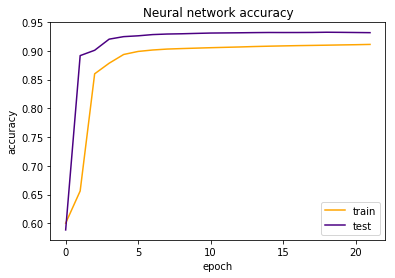

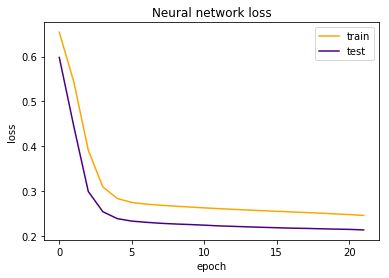

In [50]:
print(history.history.keys())


plt.plot(history.history['acc'], c = "orange")
plt.plot(history.history['val_acc'], c= "indigo")
plt.title('Neural network accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'], c = "orange")
plt.plot(history.history['val_loss'], c= "indigo")
plt.title('Neural network loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper right')
plt.xlabel('epoch')
plt.show()

# fileDir = os.path.join("D:\\Dropbox\\SonicationBehavior\\NNVid")
# for jj in np.arange(1, len(history.history['acc'])):#range(len(history.history['acc'])):

#     # summarize history for accuracy
#     plt.figure(figsize = (4,3))
    
#     plt.plot(history.history['acc'][0:jj], c = "orange")
#     plt.plot(history.history['val_acc'][0:jj], c= "indigo")
#     plt.scatter(jj-1, history.history['acc'][jj-1], s= 5, c= "orange")
#     plt.scatter(jj-1, history.history['val_acc'][jj-1], s= 5, c= "indigo")
#     plt.title('Neural network accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='lower right')
#     plt.ylim(0.4, 1)
#     plt.xlim(0, )
#     plt.xticks(np.arange(0,jj, step = 10))
#     plt.set_cmap("Purples")
#     plt.tight_layout()
#     plt.savefig(os.path.join(fileDir, str(jj).zfill(4) + ".png"), dpi = 100)
#     plt.show()

In [51]:
preds = model.predict(Xtest)

In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(preds>=0.5, Ytest)

0.8978256747092354

In [ ]:
# random search
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier as rfc

# build a classifier
clf = rfc( n_jobs = 5)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [10],
              "n_estimators": sp_randint(1, 100),
              "bootstrap": [True],
              "criterion": ["gini"]}

# run randomized search
n_iter_search = 3
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs = 5)

start = time.time()
random_search.fit(Xtrain, Ytrain)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

In [ ]:
preds = random_search.predict(Xtest)
from sklearn.metrics import accuracy_score
accuracy_score(preds, Ytest)

In [ ]:
# read in each recording, and calculate variance for different parts of the recordings

kk = 3
tmpRec = readMyFile(buzzClass.fileName[kk])

class BuzzNoiseWing:
    
    '''
    Splits recording into buzz, noise, wingbeat
    
    '''
    def __init__(self, fileName):
        self.fileName = fileName
        self.recording = readMyFile(fileName)
        self.metaDat = buzzClass.loc[buzzClass.fileName == self.fileName, :]
        self.noisePts = np.array(self.metaDat.iloc[0, 1:3]).astype(int)
        self.wingPts = np.array(self.metaDat.iloc[0, 3:5]).astype(int)
        self.buzzPts = np.array(self.metaDat.iloc[0, 5:7]).astype(int)
        self.buzzParts = self.recording.iloc[np.arange(self.buzzPts[0], self.buzzPts[1]),:]
        self.noiseParts = self.recording.iloc[np.arange(self.noisePts[0], self.noisePts[1]),:]
        self.wingParts = self.recording.iloc[np.arange(self.wingPts[0], self.wingPts[1]),:]
        
    def euclidean_dist(self, x): # same as L2 Norm
        return x.dot(x)/len(x)
    
    def calcParts(self, plot = False, smallPlot = False):
        
        self.noiseWingBuzz = []
        for recPart in [self.noiseParts, self.wingParts, self.buzzParts]:
            self.sig = []
            
            print(recPart.shape)
            
            if (recPart.shape[0] > 0):
                # process parts of recording
                self.sig = np.array(recPart.iloc[:,1]*1000 / 10.17)
                sigProc = fft_(recPart.iloc[:,0], self.sig)
                sigProc.fft_fit(sigProc.sigl)
                if plot:
                    sigProc.plot_fft(title = "Original Acceleration")

                sigProc.filterAcc()
                if plot:
                    plt.plot(sigProc.filtered_acc)
                    plt.grid(True)
                sigProc.fft_fit(sigProc.filtered_acc)
                if plot:
                    sigProc.plot_fft(title = "Filtered Acceleration")
                #self.accVars = pd.Series(sigProc.filtered_acc - np.mean(sigProc.filtered_acc)).rolling(int(3000), center = True, min_periods = 1).apply(self.euclidean_dist).tolist()
                #self.accVars = pd.Series((sigProc.filtered_acc - np.mean(sigProc.filtered_acc))).rolling(int(3000), center = True, min_periods = 1).var().tolist()
                self.accVars = pd.Series(abs(sigProc.filtered_acc - np.mean(sigProc.filtered_acc))).rolling(int(3000), center = True, min_periods = 1).max().tolist()

                if plot or smallPlot:
                    plt.plot(self.accVars)
                    plt.show()
                    print(np.mean(self.accVars))
                self.noiseWingBuzz.append(np.mean(self.accVars))
            else:
                self.noiseWingBuzz.append(np.nan)

                

        

kk +=1
tt = BuzzNoiseWing(buzzClass.fileName[kk])
tt.calcParts(plot = True, smallPlot = True)

# sample a random recording
# save example figures

#ii = np.random.randint(low = 0, high = hl.shape[0], size = 1)[0]
buzzFile = os.path.join(dd, hl.accFileAndFolder[ii].split("_ampFreq.txt")[0].replace("/", "\\"), hl.accFile[ii])
#buzzFile = combinedDF.loc[combinedDF.noiseVar > 10,"fileName"].tolist()[0]#
tmpdf1 = readMyFile(buzzFile)
timesteps = tmpdf1.iloc[:,0 ]
sig = np.array(tmpdf1.iloc[:,1]*1000 / 10.17)


sigProc = fft_(timesteps, sig)
sigProc.fft_fit(sigProc.sigl)
print(sigProc.dominant_freq, hl.accFile[ii])
sigProc.plot_fft(title = "Unfiltered acceleration", ylab = "Acceleration (m/s/s)", showPlt = False)
plt.savefig(os.path.join(figDir, "UnfilteredAccExample.pdf"), width = 10, height = 4)
plt.show()

sigProc.filterAcc()
#plt.plot(sigProc.filtered_acc)
#plt.grid(True)
sigProc.fft_fit(sigProc.filtered_acc)
sigProc.plot_fft(title = "Filtered acceleration", ylab = "Acceleration (m/s/s)", showPlt=False)
plt.savefig(os.path.join(figDir, "FilteredAccExample.pdf"), width = 10, height = 4)
plt.show()

sigProc.doubleIntegrate(sigProc.filtered_sigl)
sigProc.fft_fit(sigProc.pos_unfilt)
sigProc.plot_fft(title =  "Unfiltered position", ylab = "Position (m)", showPlt = False)
plt.savefig(os.path.join(figDir, "UnfilteredPositionExample.pdf"), width = 10, height = 4)
plt.show()


sigProc.fft_fit(sigProc.pos)
sigProc.plot_fft(title =  "Filtered position", ylab = "Position (m)", showPlt = False)
plt.savefig(os.path.join(figDir, "FilteredPosExample.pdf"), width = 10, height = 4)
plt.show()



# envelope
accMxs = pd.Series(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc))).rolling(int(1000), center = True, min_periods = 1).max().tolist()
plt.plot(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc)))
plt.plot(accMxs)
plt.show()


mxs = pd.Series(abs(sigProc.pos)).rolling(int(700), center = True, min_periods = 1).max().tolist()
# plt.plot(abs(sigProc.pos -np.mean(sigProc.pos)))
# plt.plot(mxs)
# plt.show()

aa = np.array(np.where((np.array(accMxs) > 2.5) & (np.arange(0, len(accMxs)) < 18000) & (np.arange(0, len(accMxs)) > 2000)))
bb = aa.flatten()

if bb.shape[0] > 0:

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(sigProc.timesteps[0:(len(sigProc.pos))],sigProc.pos*1000,  alpha = 0.2, c="black" )
    #ax.set_title("Position signal with sonication")

    cc = sigProc.timesteps[0:(len(sigProc.pos))]
    
    ax.plot(cc[bb], sigProc.pos[bb]*1000, c= 'black')

    maxCut = np.array(mxs)[bb]
    mm = np.mean((maxCut))
    ax.set_xlim(0,0.1)
    ax.set_ylabel("Position (mm)")
    ax.set_xlabel("Time (s)")

    ax.hlines(xmin = -0.01, xmax =np.max(cc[bb]), y = [mm*1000, - mm*1000], colors = 'grey',   linestyles= "--")
    #plt.plot(mxs)
    plt.tight_layout()
    plt.savefig(os.path.join(figDir, "PositionBuzzAccented.pdf"), width = 10, height = 7)
    print(np.mean(np.unique(mm)))

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [ ]:
# Generate dummy data
x_train = np.random.random((1000, 20))
y_train = np.random.randint(2, size=(1000, 1))
x_test = np.random.random((100, 20))
y_test = np.random.randint(2, size=(100, 1))

model = Sequential()
model.add(Dense(64, input_dim=20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=20,
          batch_size=128)
score = model.evaluate(x_test, y_test, batch_size=128)

In [ ]:
import os
print(os.environ['Path'])

In [ ]:
# visualization
from keras.utils import plot_model
import pydot
plot_model(model, to_file=os.path.join(figDir,'modelTest.png'))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

data_dim = 16
timesteps = 8
num_classes = 10

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(name = "HIHIH")
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, data_dim), name = "First_LSTM"))  # returns a sequence of vectors of dimension 32
#model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, name = "Second_LSTM") )  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax', name = "Output_Layer_softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = np.random.random((1000, num_classes))

# Generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100, num_classes))

model.fit(x_train, y_train,
          batch_size=64, epochs=5,
          validation_data=(x_val, y_val))

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file=os.path.join(figDir,'modelExample.png'), show_shapes=True, show_layer_names=True)

In [ ]:

timesteps = 100
num_classes = 4

# expected input data shape: (batch_size, timesteps, data_dim)

# Generate dummy training data
x_train = np.random.random((1000, timesteps))
y_train = np.floor(x_train*4)
s = pd.Series(y_train.reshape(-1, ))
aa = list(y_train.shape)
aa.append(-1)
yy = np.array(pd.get_dummies(s)).reshape(aa)
y_train = yy

x_train = x_train.reshape(1000, 100,-1 )



# Generate dummy validation data
x_val = np.random.random((1000, timesteps))
y_val = np.floor(x_val*4)
s = pd.Series(y_val.reshape(-1, ))
aa = list(y_val.shape)
aa.append(-1)
yy = np.array(pd.get_dummies(s)).reshape(aa)
y_val = yy
x_val = x_val.reshape(1000, 100,-1 )


model = Sequential()
model.add(LSTM(1, input_shape=(100,1)))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model.fit(x_train, y_train,
          batch_size=64, epochs=5)



In [ ]:
x_train = np.random.random((1000, timesteps))
y_train = np.floor(x_train*4)
s = pd.Series(y_train.reshape(-1, ))
aa = list(y_train.shape)
aa.append(-1)
yy = np.array(pd.get_dummies(s)).reshape(aa)
y_train = yy

In [ ]:
x_train.shape[1:3]

In [ ]:
x_train.shape

In [ ]:
xtrain = x_train.reshape(1000, 100,-1 )

In [ ]:
plt.plot(x_train[1,:])
plt.plot(yy[1,:,:] * 0.1)

In [ ]:
plt.plot(yy[1,:,0])

In [ ]:
'''Example script showing how to use a stateful LSTM model
and how its stateless counterpart performs.
More documentation about the Keras LSTM model can be found at
https://keras.io/layers/recurrent/#lstm
The models are trained on an input/output pair, where
the input is a generated uniformly distributed
random sequence of length = "input_len",
and the output is a moving average of the input with window length = "tsteps".
Both "input_len" and "tsteps" are defined in the "editable parameters" section.
A larger "tsteps" value means that the LSTM will need more memory
to figure out the input-output relationship.
This memory length is controlled by the "lahead" variable (more details below).
The rest of the parameters are:
- input_len: the length of the generated input sequence
- lahead: the input sequence length that the LSTM
  is trained on for each output point
- batch_size, epochs: same parameters as in the model.fit(...) function
When lahead > 1, the model input is preprocessed to a "rolling window view"
of the data, with the window length = "lahead".
This is similar to sklearn's "view_as_windows"
with "window_shape" being a single number
Ref: http://scikit-image.org/docs/0.10.x/api/skimage.util.html#view-as-windows
When lahead < tsteps, only the stateful LSTM converges because its
statefulness allows it to see beyond the capability that lahead
gave it to fit the n-point average. The stateless LSTM does not have
this capability, and hence is limited by its "lahead" parameter,
which is not sufficient to see the n-point average.
When lahead >= tsteps, both the stateful and stateless LSTM converge.
'''
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM

# ----------------------------------------------------------
# EDITABLE PARAMETERS
# Read the documentation in the script head for more details
# ----------------------------------------------------------

# length of input
input_len = 1000

# The window length of the moving average used to generate
# the output from the input in the input/output pair used
# to train the LSTM
# e.g. if tsteps=2 and input=[1, 2, 3, 4, 5],
#      then output=[1.5, 2.5, 3.5, 4.5]
tsteps = 100

# The input sequence length that the LSTM is trained on for each output point
lahead = 1

# training parameters passed to "model.fit(...)"
batch_size = 1
epochs = 20

# ------------
# MAIN PROGRAM
# ------------

print("*" * 33)
if lahead >= tsteps:
    print("STATELESS LSTM WILL ALSO CONVERGE")
else:
    print("STATELESS LSTM WILL NOT CONVERGE")
print("*" * 33)

np.random.seed(1986)

print('Generating Data...')


def gen_uniform_amp(amp=1, xn=10000):
    """Generates uniform random data between
    -amp and +amp
    and of length xn
    Arguments:
        amp: maximum/minimum range of uniform data
        xn: length of series
    """
    data_input = (np.sin(np.arange(0,10,step = 5/xn))+ 
    np.random.randn(len(np.arange(0,10,step = 5/xn)))*0.2)
    data_input = pd.DataFrame(data_input)
    return data_input

# Since the output is a moving average of the input,
# the first few points of output will be NaN
# and will be dropped from the generated data
# before training the LSTM.
# Also, when lahead > 1,
# the preprocessing step later of "rolling window view"
# will also cause some points to be lost.
# For aesthetic reasons,
# in order to maintain generated data length = input_len after pre-processing,
# add a few points to account for the values that will be lost.
to_drop = max(tsteps - 1, lahead - 1)
data_input = gen_uniform_amp(amp=0.1, xn=input_len + to_drop)

# set the target to be a N-point average of the input
expected_output = data_input.rolling(window=tsteps, center=True).mean()

# when lahead > 1, need to convert the input to "rolling window view"
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html
if lahead > 1:
    data_input = np.repeat(data_input.values, repeats=lahead, axis=1)
    data_input = pd.DataFrame(data_input)
    for i, c in enumerate(data_input.columns):
        data_input[c] = data_input[c].shift(i)

# drop the nan
expected_output = expected_output[to_drop:]
data_input = data_input[to_drop:]

print('Input shape:', data_input.shape)
print('Output shape:', expected_output.shape)
print('Input head: ')
print(data_input.head())
print('Output head: ')
print(expected_output.head())
print('Input tail: ')
print(data_input.tail())
print('Output tail: ')
print(expected_output.tail())

print('Plotting input and expected output')
plt.plot(data_input[0][:1000], '.')
plt.plot(expected_output[0][:1000], '-')
plt.legend(['Input', 'Expected output'])
plt.title('Input')
plt.show()


def create_model(stateful):
    model = Sequential()
    model.add(LSTM(20,
              input_shape=(lahead, 1),
              batch_size=batch_size,
              stateful=stateful))
    model.add(Dense(y_train.shape[1], activation = "linear"))
    
    model.compile(loss='mse', optimizer='adam')
    return model

print('Creating Stateful Model...')
model_stateful = create_model(stateful=True)


# split train/test data
def split_data(x, y, ratio=0.8):
    to_train = int(input_len * ratio)
    # tweak to match with batch_size
    to_train -= to_train % batch_size

    x_train = x[:to_train]
    y_train = y[:to_train]
    x_test = x[to_train:]
    y_test = y[to_train:]

    # tweak to match with batch_size
    to_drop = x.shape[0] % batch_size
    if to_drop > 0:
        x_test = x_test[:-1 * to_drop]
        y_test = y_test[:-1 * to_drop]

    # some reshaping
    reshape_3 = lambda x: x.values.reshape((x.shape[0], x.shape[1], 1))
    x_train = reshape_3(x_train)
    x_test = reshape_3(x_test)

    reshape_2 = lambda x: x.values.reshape((x.shape[0], 1))
    y_train = reshape_2(y_train)
    y_test = reshape_2(y_test)

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = split_data(data_input, expected_output)
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

print('Training')
for i in range(epochs):
    print('Epoch', i + 1, '/', epochs)
    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in data_input.
    # Each of these series are offset by one step and can be
    # extracted with data_input[i::batch_size].
    model_stateful.fit(x_train,
                       y_train,
                       batch_size=batch_size,
                       epochs=1,
                       verbose=1,
                       validation_data=(x_test, y_test),
                       shuffle=False)
    model_stateful.reset_states()

print('Predicting')
predicted_stateful = model_stateful.predict(x_test, batch_size=batch_size)

print('Creating Stateless Model...')
model_stateless = create_model(stateful=False)

print('Training')
model_stateless.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    shuffle=False)

print('Predicting')
predicted_stateless = model_stateless.predict(x_test, batch_size=batch_size)

# ----------------------------

print('Plotting Results')
plt.subplot(3, 1, 1)
plt.plot(y_test)
plt.title('Expected')
plt.subplot(3, 1, 2)
# drop the first "tsteps-1" because it is not possible to predict them
# since the "previous" timesteps to use do not exist
plt.plot((y_test - predicted_stateful).flatten()[tsteps - 1:])
plt.title('Stateful: Expected - Predicted')
plt.subplot(3, 1, 3)
plt.plot((y_test - predicted_stateless).flatten())
plt.title('Stateless: Expected - Predicted')
plt.show()

In [ ]:


print('Plotting input and expected output')
plt.plot(data_input[0][:1000], '.')
plt.plot(expected_output[0][:1000], '-')
plt.legend(['Input', 'Expected output'])
plt.title('Input')
plt.show()

In [ ]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
 
# create a sequence classification instance
def get_sequence(n_timesteps):    
    # create a sequence of random numbers in [0,1]
    X = array([random() for _ in range(n_timesteps)])
    # calculate cut-off value to change class values
    limit = n_timesteps/4.0
    # determine the class outcome for each item in cumulative sequence
    y = array([0 if x < limit else 1 for x in cumsum(X)])
    # reshape input and output data to be suitable for LSTMs
    X = X.reshape(1, n_timesteps, 1)
    y = y.reshape(1, n_timesteps, 1)
    return X, y
 
# define problem properties
n_timesteps = 10
# define LSTM
model = Sequential()
model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# train LSTM
for epoch in range(1000):
    # generate new random sequence
    X,y = get_sequence(n_timesteps)
    # fit model for one epoch on this sequence
    model.fit(X, y, epochs=1, batch_size=1, verbose=2)
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
    print('Expected:', y[0, i], 'Predicted', yhat[0, i])

In [ ]:
X.shape

In [ ]:
def readMyFile(filename):
    
    '''Read in csv 10x faster than pandas'''
    
    tmpdta = []
 
    with open(filename, newline="\n") as csvDataFile:
        csvReader = csv.reader(csvDataFile, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
        for row in csvReader:
            tmpdta.append(row)
 
    return(pd.DataFrame(np.transpose(tmpdta)))

In [ ]:
# fft class

class fft_:
    
    '''
    Does fft spectrum with accelerometer data
    
    '''
    def __init__(self, timesteps, sigl, cutoff = 200):
        self.timesteps = timesteps
        self.sigl = sigl - np.mean(sigl)
        self.log_rate = np.round(1/np.mean(np.diff(timesteps)))
        
    
    def butter_highpass(self, order=5):
        self.order = order
        nyq = 0.5 * self.log_rate
        normal_cutoff = self.cutoff / nyq
        b, a = signal.butter(self.order, normal_cutoff, btype='high', analog=False)
        return b,a

    def butter_highpass_filter(self, sigToFilter, cutoff = 200, order=5):
        self.cutoff = cutoff
        b, a = self.butter_highpass()
        newSig = np.concatenate([np.flip(sigToFilter[0:1000], axis = 0),
                                 sigToFilter, 
                                 np.flip(sigToFilter[(len(sigToFilter)-1000):len(sigToFilter)], axis = 0) ])
        self.newSig = newSig
        y = signal.filtfilt(b, a, newSig)
        self.filtered_sigl = y[1000:(len(sigToFilter)+1000)]
        
    
    def filterAcc(self):
        self.butter_highpass_filter(sigToFilter= self.sigl, cutoff = 220)
        self.filtered_acc = self.filtered_sigl - np.mean(self.filtered_sigl)
    
    
    def doubleIntegrate(self, sigToIntegrate):
        vel = np.cumsum(sigToIntegrate)/self.log_rate
        pos = np.cumsum(vel - np.mean(vel)) / self.log_rate
        self.pos_unfilt = pos - np.mean(pos)
        
        # highpass filter position
        self.butter_highpass_filter(sigToFilter= pos, cutoff = 100)
        self.pos = self.filtered_sigl - np.mean(self.filtered_sigl)
         
    
    def fft_fit(self, inputSignal):
        n =len(inputSignal) # length of the sigl
        k = np.arange(n, step = 1)
        T = n/self.log_rate
        frq = k/T # two sides frequency range
        frq = frq[range(int(n/2))] # one side frequency range

        # fft computing and normalization (note that *2 is so that it is scaled properly)
        Y = np.fft.fft(inputSignal)/n *2 
        Y = Y[range(int(n/2))]

        # calculate top frequency
        ind = np.argpartition(abs(Y), -4)[-4:]
        
        # Find highest point on the spectrum
        self.peakFrq = frq[ind[::-1]]
        self.pwr = (abs(Y)[ind[::-1]])
        
        self.dominant_freq = [x for (y,x) in sorted(zip(self.pwr,self.peakFrq), reverse = True)][0]
        self.max_amp = self.pwr[self.peakFrq == self.dominant_freq]
        self.Y = Y
        self.frq = frq
        self.fftSignal = inputSignal
        
        
        
    def plot_fft(self, title = "", ylab = "", showPlt = True):    
        plt.figure(figsize=(10,4))
        gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

        # create subplot 1
        ax1 = plt.subplot(gs[0])
        ax1.plot(self.timesteps[0:len(self.fftSignal)],self.fftSignal, color = 'black', linewidth=0.5)
        ax1.set_title(title + " signal")
        ax1.set_ylabel(ylab)
        ax1.set_xlabel("Time (s)")
    
        # subplot 2
        ax2 = plt.subplot(gs[1])
        ax2.plot(self.frq, abs(self.Y), color = "black", linewidth=0.5)
        ax2.set_ylabel(ylab)
        ax2.set_xlabel("Frequency (Hz)")
        if(not np.isinf(self.dominant_freq)):
            ax2.plot(self.dominant_freq, self.max_amp,'o', color = 'black', markersize = 5)
            ax2.annotate(str(self.dominant_freq) + ' Hz', 
                     xy=(self.dominant_freq, self.max_amp), 
                     xytext=(self.dominant_freq + 40, 
                             self.max_amp-0.01*self.max_amp), size = 12)
            ax2.set_xlim(-0, 1003)
            ax2.set_title(title + " FFT spectrum")
        if showPlt: 
            plt.show()

In [ ]:
def windowsOrMacDirectories():
    """ Sets base directories for win or mac

       
    """
    if os.environ['COMPUTERNAME'] == 'SHEALMACLEARN':
        DropboxDirect = os.path.join("D:\Dropbox")
#     elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
#         # this excludes your current terminal "/dev/tty"
    elif sys.platform.startswith('darwin'):
        DropboxDirect = os.path.join("/Users/cswitzer/Dropbox")
    else:
        raise EnvironmentError('Unknown computer platform')
    
    baseDir = os.getcwd()
    dataDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehData')
    figDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehFigs')
    return baseDir, dataDir, figDir


baseDir, dataDir, figDir = windowsOrMacDirectories()

In [ ]:
# Read in Heavy/Light data
HeavyLight = os.path.join(dataDir, "02_HeavyLight_cleaned.csv")
hl = pd.read_csv(HeavyLight)
hl.head()

dd = os.path.join(dataDir, "SonicationBehavior_HeavyLight")

allFolders = np.unique(hl.accFileAndFolder)

# sample a random recording
# save example figures

#ii = np.random.randint(low = 0, high = hl.shape[0], size = 1)[0]
buzzFile = os.path.join(dd, hl.accFileAndFolder[ii].split("_ampFreq.txt")[0].replace("/", "\\"), hl.accFile[ii])
#buzzFile = combinedDF.loc[combinedDF.noiseVar > 10,"fileName"].tolist()[0]#
tmpdf1 = readMyFile(buzzFile)
timesteps = tmpdf1.iloc[:,0 ]
sig = np.array(tmpdf1.iloc[:,1]*1000 / 10.17)


sigProc = fft_(timesteps, sig)
sigProc.fft_fit(sigProc.sigl)
print(sigProc.dominant_freq, hl.accFile[ii])
sigProc.plot_fft(title = "Unfiltered Acceleration", ylab = "Acceleration (m/s/s)")

sigProc.filterAcc()
plt.plot(sigProc.filtered_acc)
plt.grid(True)
sigProc.fft_fit(sigProc.filtered_acc)
sigProc.plot_fft(title = "Filtered Acceleration", ylab = "Acceleration (m/s/s)")

sigProc.doubleIntegrate(sigProc.filtered_sigl)
sigProc.fft_fit(sigProc.pos_unfilt)
#sigProc.plot_fft(title =  "Position (no filt)")

sigProc.fft_fit(sigProc.pos)
sigProc.plot_fft(title =  "Position (h.p. filt'd')")


# envelope
accMxs = pd.Series(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc))).rolling(int(2000), center = True, min_periods = 1).max().tolist()
plt.plot(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc)))
plt.plot(accMxs)
plt.show()


mxs = pd.Series(abs(sigProc.pos)).rolling(int(700), center = True, min_periods = 1).max().tolist()
# plt.plot(abs(sigProc.pos -np.mean(sigProc.pos)))
# plt.plot(mxs)
# plt.show()

aa = np.array(np.where((np.array(accMxs) > 2.0) & (np.arange(0, len(accMxs)) < 18000) & (np.arange(0, len(accMxs)) > 2000)))
bb = aa.flatten()

if bb.shape[0] > 0:

    plt.plot(sigProc.pos )
    plt.title("position with amplitude drawn")


    plt.plot(bb, sigProc.pos[bb])

    maxCut = np.array(mxs)[bb]
    mm = np.mean(np.unique(maxCut))

    plt.hlines(xmin = 0, xmax = 20000, y = [mm, - mm])
    print(np.mean(np.unique(mm)))


In [ ]:
# # write data to .csv file
# buzzClassDataDir = os.path.join("D:\Dropbox\SonicationBehavior\SonBehData\BuzzPartClassification")
# buzzClassDataDir

# noise = [0,0]
# wing = [ 0,0]
# buzz = [0,20000]

# if(not os.path.exists(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))):
#     with open(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'), 'a') as the_file: 
#         print("Writing Header")
#         the_file.write('fileName,noise1,noise2,wing1,wing2,buzz1,buzz2\n')
        


# with open(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'), 'a') as the_file: 
#     the_file.write(str(buzzFile) + "," + ','.join(map(str, np.hstack([noise, wing, buzz]))) + "\n")

___

### learn from manually-classified data

___

In [ ]:
buzzClassDataDir = os.path.join("D:\Dropbox\SonicationBehavior\SonBehData\BuzzPartClassification")
buzzClass = pd.read_csv(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))
print(buzzClass.shape)
buzzClass.head()


# remove duplicated rows
buzzClass.drop_duplicates(subset = "fileName", inplace = True)
buzzClass.reset_index(drop = True, inplace = True)
buzzClass.shape

# read in each recording, and calculate variance for different parts of the recordings

kk = 3
tmpRec = readMyFile(buzzClass.fileName[kk])

class BuzzNoiseWing:
    
    '''
    Splits recording into buzz, noise, wingbeat
    
    '''
    def __init__(self, fileName):
        self.fileName = fileName
        self.recording = readMyFile(fileName)
        self.metaDat = buzzClass.loc[buzzClass.fileName == self.fileName, :]
        self.noisePts = np.array(self.metaDat.iloc[0, 1:3]).astype(int)
        self.wingPts = np.array(self.metaDat.iloc[0, 3:5]).astype(int)
        self.buzzPts = np.array(self.metaDat.iloc[0, 5:7]).astype(int)
        self.buzzParts = self.recording.iloc[np.arange(self.buzzPts[0], self.buzzPts[1]),:]
        self.noiseParts = self.recording.iloc[np.arange(self.noisePts[0], self.noisePts[1]),:]
        self.wingParts = self.recording.iloc[np.arange(self.wingPts[0], self.wingPts[1]),:]
        
    def euclidean_dist(self, x): # same as L2 Norm
        return x.dot(x)/len(x)
    
    def calcParts(self, plot = False, smallPlot = False):
        
        self.noiseWingBuzz = []
        for recPart in [self.noiseParts, self.wingParts, self.buzzParts]:
            self.sig = []
            
            print(recPart.shape)
            
            if (recPart.shape[0] > 0):
                # process parts of recording
                self.sig = np.array(recPart.iloc[:,1]*1000 / 10.17)
                sigProc = fft_(recPart.iloc[:,0], self.sig)
                sigProc.fft_fit(sigProc.sigl)
                if plot:
                    sigProc.plot_fft(title = "Original Acceleration")

                sigProc.filterAcc()
                if plot:
                    plt.plot(sigProc.filtered_acc)
                    plt.grid(True)
                sigProc.fft_fit(sigProc.filtered_acc)
                if plot:
                    sigProc.plot_fft(title = "Filtered Acceleration")
                #self.accVars = pd.Series(sigProc.filtered_acc - np.mean(sigProc.filtered_acc)).rolling(int(3000), center = True, min_periods = 1).apply(self.euclidean_dist).tolist()
                #self.accVars = pd.Series((sigProc.filtered_acc - np.mean(sigProc.filtered_acc))).rolling(int(3000), center = True, min_periods = 1).var().tolist()
                self.accVars = pd.Series(abs(sigProc.filtered_acc - np.mean(sigProc.filtered_acc))).rolling(int(3000), center = True, min_periods = 1).max().tolist()

                if plot or smallPlot:
                    plt.plot(self.accVars)
                    plt.show()
                    print(np.mean(self.accVars))
                self.noiseWingBuzz.append(np.mean(self.accVars))
            else:
                self.noiseWingBuzz.append(np.nan)

                

        

kk +=1
tt = BuzzNoiseWing(buzzClass.fileName[kk])
tt.calcParts(plot = True, smallPlot = True)

# sample a random recording
# save example figures

#ii = np.random.randint(low = 0, high = hl.shape[0], size = 1)[0]
buzzFile = os.path.join(dd, hl.accFileAndFolder[ii].split("_ampFreq.txt")[0].replace("/", "\\"), hl.accFile[ii])
#buzzFile = combinedDF.loc[combinedDF.noiseVar > 10,"fileName"].tolist()[0]#
tmpdf1 = readMyFile(buzzFile)
timesteps = tmpdf1.iloc[:,0 ]
sig = np.array(tmpdf1.iloc[:,1]*1000 / 10.17)


sigProc = fft_(timesteps, sig)
sigProc.fft_fit(sigProc.sigl)
print(sigProc.dominant_freq, hl.accFile[ii])
sigProc.plot_fft(title = "Unfiltered acceleration", ylab = "Acceleration (m/s/s)", showPlt = False)
plt.savefig(os.path.join(figDir, "UnfilteredAccExample.pdf"), width = 10, height = 4)
plt.show()

sigProc.filterAcc()
#plt.plot(sigProc.filtered_acc)
#plt.grid(True)
sigProc.fft_fit(sigProc.filtered_acc)
sigProc.plot_fft(title = "Filtered acceleration", ylab = "Acceleration (m/s/s)", showPlt=False)
plt.savefig(os.path.join(figDir, "FilteredAccExample.pdf"), width = 10, height = 4)
plt.show()

sigProc.doubleIntegrate(sigProc.filtered_sigl)
sigProc.fft_fit(sigProc.pos_unfilt)
sigProc.plot_fft(title =  "Unfiltered position", ylab = "Position (m)", showPlt = False)
plt.savefig(os.path.join(figDir, "UnfilteredPositionExample.pdf"), width = 10, height = 4)
plt.show()


sigProc.fft_fit(sigProc.pos)
sigProc.plot_fft(title =  "Filtered position", ylab = "Position (m)", showPlt = False)
plt.savefig(os.path.join(figDir, "FilteredPosExample.pdf"), width = 10, height = 4)
plt.show()



# envelope
accMxs = pd.Series(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc))).rolling(int(1000), center = True, min_periods = 1).max().tolist()
plt.plot(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc)))
plt.plot(accMxs)
plt.show()


mxs = pd.Series(abs(sigProc.pos)).rolling(int(700), center = True, min_periods = 1).max().tolist()
# plt.plot(abs(sigProc.pos -np.mean(sigProc.pos)))
# plt.plot(mxs)
# plt.show()

aa = np.array(np.where((np.array(accMxs) > 2.5) & (np.arange(0, len(accMxs)) < 18000) & (np.arange(0, len(accMxs)) > 2000)))
bb = aa.flatten()

if bb.shape[0] > 0:

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(sigProc.timesteps[0:(len(sigProc.pos))],sigProc.pos*1000,  alpha = 0.2, c="black" )
    #ax.set_title("Position signal with sonication")

    cc = sigProc.timesteps[0:(len(sigProc.pos))]
    
    ax.plot(cc[bb], sigProc.pos[bb]*1000, c= 'black')

    maxCut = np.array(mxs)[bb]
    mm = np.mean((maxCut))
    ax.set_xlim(0,0.1)
    ax.set_ylabel("Position (mm)")
    ax.set_xlabel("Time (s)")

    ax.hlines(xmin = -0.01, xmax =np.max(cc[bb]), y = [mm*1000, - mm*1000], colors = 'grey',   linestyles= "--")
    #plt.plot(mxs)
    plt.tight_layout()
    plt.savefig(os.path.join(figDir, "PositionBuzzAccented.pdf"), width = 10, height = 7)
    print(np.mean(np.unique(mm)))


In [ ]:
bigNoiseWingBuzzVar = []

for kk in np.arange(buzzClass.shape[0]):
    print(kk)
    tt = BuzzNoiseWing(buzzClass.fileName[kk])
    tt.calcParts()
    bigNoiseWingBuzzVar.append(tt.noiseWingBuzz)

In [ ]:
varDF = pd.DataFrame(bigNoiseWingBuzzVar)
varDF

In [ ]:
combinedDF = pd.concat([buzzClass.reset_index(drop=True), varDF], axis = 1)
combinedDF.rename(columns = {0:'noiseVar', 1:'wingVar', 2:'buzzVar'}, inplace = True)


In [ ]:
bin_size = 0.5; min_edge = 0; max_edge = 20
N = (max_edge-min_edge)/bin_size; Nplus1 = int(N) + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)



fig, axes = plt.subplots(nrows=1, ncols=1)
ax0 = axes
n_bins = 10
x = np.array([np.hstack([combinedDF.noiseVar[~np.isnan(combinedDF.noiseVar)], 
                                   combinedDF.wingVar[~np.isnan(combinedDF.wingVar)]]), 
               combinedDF.buzzVar[(~np.isnan(combinedDF.buzzVar)) & (combinedDF.buzzVar<20)]])
colors = ['Signal Noise or Wingbeat', 'Sonication']
ax0.hist(x, bin_list, normed=1, histtype='bar', label=colors)
ax0.legend(prop={'size': 10})
ax0.set_ylabel("Density")
ax0.set_xlabel("Variance of accelerations")
ax0.set_xlim(0, 10)
#ax0.set_title('Noise, Wingbeat, and Sonications')
plt.savefig(os.path.join(figDir, "SonicationClassificationVars.pdf"), width = 5, height = 4)

In [ ]:
sns.distplot(x[1], bins=bin_list, label = "Sonication")
sns.distplot(x[0],bins=bin_list, label = "Signal Noise or Wingbeat")
plt.xlabel("Variance of accelerations")
plt.ylabel("Density")
plt.legend()
plt.xlim(0, 15)
plt.savefig(os.path.join(figDir, "SonicationClassificationDensityVars.pdf"), width = 5, height = 4)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)
ax3 = axes
ax3.hist(x, n_bins, histtype='step', stacked=False, normed = 1)
ax3.set_title('different sample sizes')

In [ ]:
combinedDF.loc[combinedDF.buzzVar < 2, :]

In [ ]:
kk = 62
tt = BuzzNoiseWing(buzzClass.fileName[kk])
tt.calcParts(plot = True, smallPlot = True)

In [ ]:
aa = readMyFile(buzzClass.fileName[kk])
plt.plot(aa)

In [ ]:
sig = np.array(tt.buzzParts.iloc[:,1]*1000 / 10.17)
sigProc = fft_(tt.buzzParts.iloc[:,0], sig)
sigProc.fft_fit(sigProc.sigl)

plt.plot(sigProc.sigl)
sigProc.dominant_freq
sigProc.plot_fft(title = "Original Acceleration")
sigProc.filterAcc()
plt.plot(sigProc.filtered_acc)
plt.grid(True)

In [ ]:
sigProc.fft_fit(sigProc.filtered_acc)
len(sigProc.fftSignal)
sigProc.plot_fft(title = "Filtered Acceleration")

In [ ]:
accMxs = pd.Series(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc))).rolling(int(1000), center = True, min_periods = 1).var().tolist()
plt.plot(accMxs)
plt.show()

In [ ]:
def fft_fit(inputSignal, log_rate = 20000):
    n =len(inputSignal) # length of the sigl
    k = np.arange(n, step = 1)
    T = n/log_rate
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    # fft computing and normalization (note that *2 is so that it is scaled properly)
    Y = np.fft.fft(inputSignal)/n *2 
    Y = Y[range(int(n/2))]

    # calculate top frequency
    ind = np.argpartition(abs(Y), -4)[-4:]

    # Find highest point on the spectrum
    peakFrq = frq[ind[::-1]]
    pwr = (abs(Y)[ind[::-1]])

    dominant_freq = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]
    max_amp = pwr[peakFrq == dominant_freq]
    Y = Y
    frq = frq
    fftSignal = inputSignal
    return(peakFrq, pwr, dominant_freq, max_amp, Y, frq, fftSignal)

In [ ]:
peakFrq, pwr, dominant_freq, max_amp, Y, frq, fftSignal = fft_fit(sigProc.sigl)
plt.plot(abs(Y))

In [ ]:
sigProc.filterAcc()
plt.plot(sigProc.filtered_acc)
plt.grid(True)
sigProc.fft_fit(sigProc.filtered_acc)
sigProc.plot_fft(title = "Filtered Acceleration")
accMxs = pd.Series(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc))).rolling(int(1000), center = True, min_periods = 1).var().tolist()
plt.plot(accMxs)
plt.show()

In [ ]:
plt.plot(tt.buzzParts.iloc[:,0], tt.sig)

In [ ]:
sigProc.fft_fit(sigProc.sigl)
sigProc.plot_fft(title = "Original Acceleration")
sigProc.filterAcc()
plt.plot(sigProc.filtered_acc)
plt.grid(True)
sigProc.fft_fit(sigProc.filtered_acc)
sigProc.plot_fft(title = "Filtered Acceleration")
accMxs = pd.Series(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc))).rolling(int(1000), center = True, min_periods = 1).var().tolist()
plt.plot(accMxs)

In [ ]:
plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

# create subplot 1
ax1 = plt.subplot(gs[0])
ax1.plot(sigProc.timesteps[0:len(sigProc.fftSignal)],sigProc.fftSignal, color = 'black', linewidth=0.5)
ax1.set_title(title + " signal")

In [ ]:
sigProc.timesteps[0:len(sigProc.fftSignal)].shape
sigProc.fftSignal.shape

In [ ]:
metaDat = buzzClass.loc[buzzClass.fileName == tt.fileName, :]
noisePts = np.array(metaDat.iloc[0, 1:3]).astype(int)
wingPts = np.array(metaDat.iloc[0, 3:5]).astype(int)
buzzPts = np.array(metaDat.iloc[0, 5:7]).astype(int)

In [ ]:
wingPts



In [ ]:
not os.path.exists(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))

In [ ]:
foldNum = 2
try:
    ii += 1
except NameError:
    print("well, it WASN'T defined after all!")
    ii = 0

tmpF = os.path.join(dd, allFolders[foldNum])
tmpDF = pd.read_csv(tmpF, header = None)
tmpDF.columns = ["frq", "MaxMinAmp", "fname_short", "dd", "TT", "AA", "BB"]
tmpDF.fname_short = [ff.strip() for ff in tmpDF.fname_short]

fold = os.path.join(dd, allFolders[foldNum]).split("_ampFreq.txt")[0]

accRecs = [f for f in os.listdir(fold) if not f.startswith(".") ]

ar = accRecs[ii]
tmpdf1 = readMyFile(os.path.join(fold, ar))
timesteps = tmpdf1.iloc[:,0 ]
sig = np.array(tmpdf1.iloc[:,1]*1000 / 10.17)

# timesteps = np.linspace(0, 0.1, num = 20000)
# sig = 3.0*np.sin(369*2*np.pi*(timesteps + 0.003)) 

sigProc = fft_(timesteps, sig)
sigProc.fft_fit(sigProc.sigl)
sigProc.plot_fft(title = "Original Acceleration")


sigProc.filterAcc()
#plt.plot(sigProc.newSig)
sigProc.fft_fit(sigProc.filtered_acc)
sigProc.plot_fft(title = "Filtered Acceleration")


sigProc.doubleIntegrate(sigProc.filtered_sigl)
sigProc.fft_fit(sigProc.pos_unfilt)
sigProc.plot_fft(title =  "Position (no filt)")

sigProc.fft_fit(sigProc.pos)
sigProc.plot_fft(title =  "Position (h.p. filt'd')")


# envelope
accMxs = pd.Series(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc))).rolling(int(700), center = True, min_periods = 1).max().tolist()
# plt.plot(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc)))
# plt.plot(accMxs)
# plt.show()


mxs = pd.Series(abs(sigProc.pos)).rolling(int(700), center = True, min_periods = 1).max().tolist()
# plt.plot(abs(sigProc.pos -np.mean(sigProc.pos)))
# plt.plot(mxs)
# plt.show()

aa = np.array(np.where((np.array(accMxs) > 2.0) & (np.arange(0, len(accMxs)) < 18000) & (np.arange(0, len(accMxs)) > 2000)))
bb = aa.flatten()

if bb.shape[0] > 0:

    plt.plot(sigProc.pos )
    plt.title("position with amplitude drawn")


    plt.plot(bb, sigProc.pos[bb])

    maxCut = np.array(mxs)[bb]
    mm = np.mean(np.unique(maxCut))

    plt.hlines(xmin = 0, xmax = 20000, y = [mm, - mm])
    print(np.mean(np.unique(mm)))

In [ ]:
foldNum = 2
#ii = 0

tmpF = os.path.join(dd, allFolders[foldNum])
tmpDF = pd.read_csv(tmpF, header = None)
tmpDF.columns = ["frq", "MaxMinAmp", "fname_short", "dd", "TT", "AA", "BB"]
tmpDF.fname_short = [ff.strip() for ff in tmpDF.fname_short]

fold = os.path.join(dd, allFolders[foldNum]).split("_ampFreq.txt")[0]

accRecs = [f for f in os.listdir(fold) if not f.startswith(".") ]

ar = accRecs[ii]
tmpdf1 = readMyFile(os.path.join(fold, ar))
timesteps = tmpdf1.iloc[:,0 ]
sig = np.array(tmpdf1.iloc[:,1]*1000 / 10.17)

# timesteps = np.linspace(0, 0.1, num = 20000)
# sig = 3.0*np.sin(369*2*np.pi*(timesteps + 0.003)) 

sigProc = fft_(timesteps, sig)
sigProc.fft_fit(sigProc.sigl)
sigProc.plot_fft(title = "Original Acceleration")


sigProc.filterAcc()
#plt.plot(sigProc.newSig)
sigProc.fft_fit(sigProc.filtered_acc)
sigProc.plot_fft(title = "Filtered Acceleration")


sigProc.doubleIntegrate(sigProc.filtered_sigl)
sigProc.fft_fit(sigProc.pos_unfilt)
#sigProc.plot_fft(title =  "Position (no filt)")

sigProc.fft_fit(sigProc.pos)
#sigProc.plot_fft(title =  "Position (h.p. filt'd')")


# envelope
accMxs = pd.Series((sigProc.filtered_acc - 
                    np.mean(sigProc.filtered_acc))).rolling(int(1000), 
                                                            center = True, 
                                                            min_periods = 1).var().tolist()
plt.plot(accMxs)
plt.show()

mxs = pd.Series(abs(sigProc.pos)).rolling(int(1000), center = True, min_periods = 1).max().tolist()
plt.plot(abs(sigProc.pos -np.mean(sigProc.pos)))
plt.plot(mxs)
plt.show()

aa = np.array(np.where((np.array(accMxs) > 2.0) & (np.arange(0, len(accMxs)) < 18000) & (np.arange(0, len(accMxs)) > 2000)))
bb = aa.flatten()

if bb.shape[0] > 0:

    plt.plot(sigProc.pos )
    plt.title("position with amplitude drawn")


    plt.plot(bb, sigProc.pos[bb])

    maxCut = np.array(mxs)[bb]
    mm = np.mean(np.unique(maxCut))

    plt.hlines(xmin = 0, xmax = 20000, y = [mm, - mm])
    print(np.mean(np.unique(mm)))
    
#ii += 1

In [ ]:
plt.plot(accMxs)
plt.ylim(0, 2)

In [ ]:
# exclude short sequences
cc = (np.array(accMxs) > 2.0) & (np.arange(0, len(accMxs)) < 18000) & (np.arange(0, len(accMxs)) > 2000)
lengths = np.array([[k, sum(1 for _ in i)] for k, i in it.groupby(cc)])
print(lengths)
#plt.plot(cc*1.0)

lengths[lengths[:,1]<2000,0] = 0
keepers = np.repeat(lengths[:,0], lengths[:,1])
#plt.plot(keepers*1.0)
#plt.show()

plt.plot(sigProc.pos )
plt.title("position with amplitude drawn")
bb2 = np.array(np.where(keepers)).flatten()

plt.plot(bb2, sigProc.pos[bb2])

In [ ]:
bb2 = np.array(np.where(keepers)).flatten()
plt.plot(bb2)

In [ ]:
len(aa)

In [ ]:
# try to understand rolling variance
xx = np.arange(0, 20000)

yy =  0.011*xx *np.random.randn(len(xx))#3*np.sin(2*np.pi * xx/500)* np.sin(xx/3000)

xx
plt.plot(xx, yy)

In [ ]:
accMxs = pd.Series(yy).rolling(int(5000), center = True, min_periods = 1).var().tolist()
# plt.plot(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc)))

plt.scatter(xx, yy, s = 1)
plt.plot(accMxs, c= 'r')
plt.show()

In [ ]:
def euclidean_dist(x): # same as L2 Norm
    return x.dot(x)/len(x)

#yy = 3*np.sin(2*np.pi * xx/500)* np.sin(xx/3000)
accMxs = pd.Series(yy).rolling(int(2000), center = True, min_periods = 1).apply(euclidean_dist).tolist()
# plt.plot(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc)))

plt.scatter(xx, yy, s = 1)
plt.plot(accMxs, c= 'r')
plt.show()

In [ ]:
20000 / 500

In [ ]:
def varNoMean(x):
    return np.sum((x)**2)/len(x)

#yy = 3*np.sin(2*np.pi * xx/500)* np.sin(xx/3000)
accMxs = pd.Series(yy).rolling(int(500), center = True, min_periods = 1).apply(varNoMean).tolist()
# plt.plot(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc)))

plt.scatter(xx, yy, s = 1)
plt.plot(accMxs, c= 'r')
plt.show()

accMxs = pd.Series(yy).rolling(int(500), center = True, min_periods = 1).var().tolist()
# plt.plot(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc)))

plt.scatter(xx, yy, s = 1)
plt.plot(accMxs, c= 'r')
plt.show()

In [ ]:
np.sum((xx - np.mean(xx))**2)/len(xx)
np.var(xx)

In [ ]:
# why does position sometimes have a slope?  does it depend on phase? 
bb.shape


In [ ]:
newSig = np.concatenate([np.flip(sigProc.sigl[0:5000], axis = 0),sigProc.sigl, sigProc.sigl[15000:len(sigProc.sigl)]])
plt.plot(newSig)

In [ ]:
for foldNum in range(len(allFolders)):
    tmpF = os.path.join(dd, allFolders[foldNum])
    tmpDF = pd.read_csv(tmpF, header = None)
    tmpDF.columns = ["frq", "MaxMinAmp", "fname_short", "dd", "TT", "AA", "BB"]
    tmpDF.fname_short = [ff.strip() for ff in tmpDF.fname_short]



    fold = os.path.join(dd, allFolders[foldNum]).split("_ampFreq.txt")[0]

    accRecs = [f for f in os.listdir(fold) if not f.startswith(".") ]



    for ii in range(len(accRecs)):
        # read in data
        ar = accRecs[ii]
        tmpdf1 = readMyFile(os.path.join(fold, ar))

        # compute fft and save
        fft = fft_()

        # convert signal to m/s/s (*1000 / 10.17)
        fft.fit(timesteps = tmpdf1.iloc[:,0 ], signal = np.array(tmpdf1.iloc[:,1]*1000 / 10.17))
        #print(fft.dominant_freq, fft.max_amp)

        if ii == 0:
            tmpDF2 = np.hstack([ar, fft.dominant_freq, fft.max_amp[0], fft.amp_pos])

        else:
            tmpDF2 = np.vstack([tmpDF2, np.hstack([ar, int(fft.dominant_freq), fft.max_amp[0], fft.amp_pos])])
        
        #print(fft.dominant_freq)
        #fft.plot_fft()

    tmpDF2 = pd.DataFrame(tmpDF2)
    tmpDF2.columns = ["filename", "freq", "acc_amplitude_fft", "pos_amplitude_fft" ]
    tmpDF2.sort_values(by = "filename", inplace = True)
    tmpDF2.reset_index(inplace = True, drop = True)
    tmpDF2["fname_short"] = ["_".join(tmpDF2.filename[jj].split("_")[0:8]) for jj in range(len(tmpDF2))]


    tmpDF3 = pd.merge(tmpDF2, tmpDF, how = "outer", left_on = "fname_short", right_on = "fname_short")
    tmpDF3["Folder"] = fold.split("/")[-2]

    if(foldNum == 0):
        bigDF = pd.DataFrame(tmpDF3) 
    else:
        bigDF = pd.concat([bigDF, tmpDF3])
    
    print(foldNum)

bigDF.reset_index(drop = True, inplace = True)
bigDF.freq = pd.to_numeric(bigDF.freq)
bigDF.acc_amplitude_fft = pd.to_numeric(bigDF.acc_amplitude_fft)
bigDF.pos_amplitude_fft = pd.to_numeric(bigDF.pos_amplitude_fft)

In [ ]:
for foldNum in range(len(allFolders)):
    tmpF = os.path.join(dd, allFolders[foldNum])
    tmpDF = pd.read_csv(tmpF, header = None)
    tmpDF.columns = ["frq", "MaxMinAmp", "fname_short", "dd", "TT", "AA", "BB"]
    tmpDF.fname_short = [ff.strip() for ff in tmpDF.fname_short]



    fold = os.path.join(dd, allFolders[foldNum]).split("_ampFreq.txt")[0]

    accRecs = [f for f in os.listdir(fold) if not f.startswith(".") ]



    for ii in range(len(accRecs)):
        # read in data
        ar = accRecs[ii]
        tmpdf1 = readMyFile(os.path.join(fold, ar))

        # compute fft and save
        fft = fft_()

        # convert signal to m/s/s (*1000 / 10.17)
        fft.fit(timesteps = tmpdf1.iloc[:,0 ], signal = np.array(tmpdf1.iloc[:,1]*1000 / 10.17))
        #print(fft.dominant_freq, fft.max_amp)

        if ii == 0:
            tmpDF2 = np.hstack([ar, fft.dominant_freq, fft.max_amp[0], fft.amp_pos])

        else:
            tmpDF2 = np.vstack([tmpDF2, np.hstack([ar, int(fft.dominant_freq), fft.max_amp[0], fft.amp_pos])])
        
        #print(fft.dominant_freq)
        #fft.plot_fft()

    tmpDF2 = pd.DataFrame(tmpDF2)
    tmpDF2.columns = ["filename", "freq", "acc_amplitude_fft", "pos_amplitude_fft" ]
    tmpDF2.sort_values(by = "filename", inplace = True)
    tmpDF2.reset_index(inplace = True, drop = True)
    tmpDF2["fname_short"] = ["_".join(tmpDF2.filename[jj].split("_")[0:8]) for jj in range(len(tmpDF2))]


    tmpDF3 = pd.merge(tmpDF2, tmpDF, how = "outer", left_on = "fname_short", right_on = "fname_short")
    tmpDF3["Folder"] = fold.split("/")[-2]

    if(foldNum == 0):
        bigDF = pd.DataFrame(tmpDF3) 
    else:
        bigDF = pd.concat([bigDF, tmpDF3])
    
    print(foldNum)

bigDF.reset_index(drop = True, inplace = True)
bigDF.freq = pd.to_numeric(bigDF.freq)
bigDF.acc_amplitude_fft = pd.to_numeric(bigDF.acc_amplitude_fft)
bigDF.pos_amplitude_fft = pd.to_numeric(bigDF.pos_amplitude_fft)

In [ ]:
bigM = []

for foldNum in  range(len(allFolders)):
    tmpF = os.path.join(dd, allFolders[foldNum])
    tmpDF = pd.read_csv(tmpF, header = None)
    tmpDF.columns = ["frq", "MaxMinAmp", "fname_short", "dd", "TT", "AA", "BB"]
    tmpDF.fname_short = [ff.strip() for ff in tmpDF.fname_short]



    fold = os.path.join(dd, allFolders[foldNum]).split("_ampFreq.txt")[0]

    accRecs = [f for f in os.listdir(fold) if not f.startswith(".") ]

    mm = []

    for ii in range(len(accRecs)):
            # read in data
            ar = accRecs[ii]
            tmpdf1 = readMyFile(os.path.join(fold, ar))
            signal = (tmpdf1.iloc[:,1] - np.mean(tmpdf1.iloc[:,1]))*1000 / 10.17
            times = tmpdf1.iloc[:,0]
            mxs = pd.Series(abs(signal)).rolling(int(tmpdf1.shape[0]/28), center = True, min_periods = 1).max().tolist()

            mm.append(np.unique(mxs))

    out = np.concatenate(mm).ravel()
    bigM.append(out)
    print(foldNum)
    #plt.hist(out[out <10], bins = 30, density = True)
    #plt.xlim(0, 10)
    sns.kdeplot(np.array(out[out <15]), bw=0.3)
    #plt.show()

In [ ]:

zz = np.concatenate(bigM).ravel()
plt.hist(zz[zz < 20], density = True, bins = 200)
sns.kdeplot(zz[zz < 20], bw=0.2)
plt.xlim(0, 15)
plt.show()

In [ ]:
       


ii =0
ar = accRecs[ii]
tmpdf1 = readMyFile(os.path.join(fold, ar))

signal = (tmpdf1.iloc[:,1] - np.mean(tmpdf1.iloc[:,1]))*1000 / 10.17
times = tmpdf1.iloc[:,0]
mxs = pd.Series(abs(signal)).rolling(int(tmpdf1.shape[0]/28), center = True, min_periods = 1).max().tolist()
print(int(tmpdf1.shape[0]/28))
plt.plot(abs(signal))
plt.plot(mxs)
plt.show()

plt.hist(mxs)
plt.show()

t2 = times[np.array(mxs) > 2.0]
s2 = signal[np.array(mxs) > 2.0]

fft = fft_()
fft.fit(t2, s2)
fft.plot_fft()

In [ ]:
plt.plot(np.mod(times, 0.01) > 0.005) 

In [ ]:
sig1_amp = np.round(np.mod(times, 0.01), decimals = 1)


signal = (np.mod(times, 0.01) > 0.005)*np.sin(2* np.pi * (times* 200)) #+ 0.2*np.random.randn(len(times))
signal[abs(signal)>0.9] = 2*np.sin(2* np.pi * (times[abs(signal)>0.9]* 200))

signal = signal + ~(np.mod(times, 0.01) > 0.005)*np.sin(2* np.pi * times* 1000)*0.1 #+ np.sin(2* np.pi * (times* 3))


#signal = np.sin(2* np.pi * (times* 100))
#signal[times < 0.07] = np.sin(2* np.pi * times* 1000)*0.1


#signal = 0.8*np.sin(2* np.pi * times* 400) + np.sin(2* np.pi * (times* 200 + 400))


#sig1 = np.sin(2* np.pi * times* 50)


#signal = 5.44 * np.sin(2* np.pi * times* 200) + 4 * np.sin(2* np.pi * times* 400)

#signal = lowess(signal + 0.01*np.random.randn(len(times)), times, frac = 1/20)[:,1]
plt.figure(figsize = [10,10])
plt.plot(signal)
#plt.hlines(xmin = 0, xmax = 20000, y = 0.54)

fft = fft_()
fft.fit(times, signal)
fft.plot_fft()

In [ ]:
from scipy import signal

def highpass_filter(y, sr):
    filter_stop_freq = 70  # Hz
    filter_pass_freq = 100  # Hz
    filter_order = 1001

    # High-pass filter
    nyquist_rate = sr / 2.
    desired = (0, 0, 1, 1)
    bands = (0, filter_stop_freq, filter_pass_freq, nyquist_rate)
    filter_coefs = signal.firls(filter_order, bands, desired, nyq=nyquist_rate)

    # Apply high-pass filter
    filtered_audio = signal.filtfilt(filter_coefs, [1], y)
    return filtered_audio

In [ ]:
fc = 0.1
b = 0.08
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
 
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
window = np.blackman(N)
sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)

# reverse function
sinc_func = -sinc_func
sinc_func[(N - 1) / 2] += 1

s = list(data['10 Min Std Dev'])
new_signal = np.convolve(s, sinc_func)

trace1 = go.Scatter(
    x=range(len(new_signal)),
    y=new_signal,
    mode='lines',
    name='High-Pass Filter',
    marker=dict(
        color='#424242'
    )
)

layout = go.Layout(
    title='High-Pass Filter',
    showlegend=True
)

trace_data = [trace1]
fig = go.Figure(data=trace_data, layout=layout)
py.iplot(fig, filename='fft-high-pass-filter')

In [ ]:
del signal

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
def sine_generator(timesteps, sinefreq):
    nsamples = len(timesteps)
    w = 2. * np.pi * sinefreq
    y_sine = np.sin(w * timesteps)*3.22
    result = pd.DataFrame({ 
        'data' : y_sine} ,index=timesteps)
    return result

def butter_highpass(cutoff, log_rate, order=5):
    nyq = 0.5 * log_rate
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, log_rate, order=5):
    b, a = butter_highpass(cutoff, log_rate, order=order)
    y = signal.filtfilt(b, a, data)
    return y


timesteps = np.linspace(0, 0.1, num = 20000)
log_rate = 200000 # samples per second
sine_fq = 300

sine_5Hz = sine_generator(timesteps,sine_fq)
sine_fq = 30 #Hz
sine_1Hz = sine_generator(timesteps,sine_fq)
sine = sine_5Hz + sine_1Hz
plt.plot(sine)

In [ ]:
sine = sine_5Hz + sine_1Hz
sig1_amp = np.round(np.mod(timesteps, 0.01), decimals = 1)


sig = (np.mod(timesteps, 0.01) > 0.005*3/2)*np.sin(2* np.pi * (timesteps* 300)) #+ 0.2*np.random.randn(len(times))
sig[abs(sig)>0.9] = 2*np.sin(2* np.pi * (timesteps[abs(sig)>0.9]* 300))

sig = sig + ~(np.mod(timesteps, 0.01) > 0.005)*np.sin(2* np.pi * timesteps* 1000)* 0.1 + np.sin(2* np.pi * (timesteps* 10))
sine['data'] = data
#sine['data'] = sig

In [ ]:
filtered_sine = butter_highpass_filter(sine.data, 200, log_rate)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(sine)
plt.title('generated signal')
plt.subplot(212)
plt.plot(range(len(filtered_sine)),filtered_sine)
plt.title('filtered signal')
plt.show()

In [ ]:
vel = np.cumsum(filtered_sine)/log_rate

pos = np.cumsum(vel - np.mean(vel)) / log_rate

aa = fft_()
aa.fit(timesteps, pos-np.mean(pos))
plt.figure(figsize = [15,10])
plt.plot(timesteps, pos - np.mean(pos))
plt.hlines(xmin = 0, xmax = 0.01, y = [aa.max_amp, 1.8e-06])
aa.plot_fft()
print(aa.max_amp)

In [ ]:
fft = fft_()

In [ ]:
fft.fit(timesteps, filtered_sine)

In [ ]:
fft.plot_fft()

In [ ]:
peakind = signal.find_peaks_cwt(filtered_sine, widths = np.arange(200, 400))
plt.plot(timesteps,filtered_sine)
plt.scatter(timesteps[peakind], np.array(filtered_sine)[peakind], c= 'red')

In [ ]:
 np.array(sine.data)[peakind]

In [ ]:
from scipy import signal
t = timesteps 
t= np.linspace(-1, 1, 200, endpoint=False)
sig  = sine.data
# filtered_sine 
#sig = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
widths = np.arange(1000, 2000)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.plot(sig)
plt.show()

plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

In [ ]:
# analytical calculate position amplitude
2.0 / (np.pi * 2 * 100)**2

In [ ]:
plt.plot(fft.frq,abs(fft.Y))
print(fft.amp_pos)
plt.xlim(0, 1000)

In [ ]:
vel = np.cumsum(signal)/log_rate

pos = np.cumsum(vel - np.mean(vel)) / log_rate

aa = fft_()
aa.fit(times, pos-np.mean(pos))
plt.figure(figsize = [15,10])
plt.plot(times, pos - np.mean(pos))
plt.hlines(xmin = 0, xmax = 0.01, y = [aa.max_amp, 1.8e-06])
aa.plot_fft()
print(aa.max_amp)

In [ ]:
v2 = np.diff(pos) *log_rate
a2 = np.diff(v2-np.mean(v2)) * log_rate
plt.figure(figsize = [15,10])

plt.plot(pos-np.mean(pos))
plt.show()

plt.plot(v2-np.mean(v2))
plt.show()
plt.plot(a2)
plt.show()


In [ ]:
import pdvega  # import adds vgplot attribute to pandas



In [ ]:
sig1 = np.sin(2* np.pi * times* 350)


signal = 5*np.sin(2* np.pi * times* 352)
signal[abs(sig1) < 0.99] =  sig1

#signal[signal < 0] =  signal[signal < 0]*5
signal = signal + np.random.randn(len(times))*0.4

signal.vgplot.line()

In [ ]:
#ii +=1
ar = accRecs[ii]
tmpdf1 = readMyFile(os.path.join(fold, ar))

signal = (tmpdf1.iloc[:,1] - np.mean(tmpdf1.iloc[:,1]))*1000 / 10.17
times = tmpdf1.iloc[:,0]
mxs = pd.Series(abs(signal)).rolling(int(tmpdf1.shape[0]/28), center = True, min_periods = 1).max().tolist()
print(int(tmpdf1.shape[0]/28))
plt.plot(abs(signal))
plt.plot(mxs)

plt.show()
plt.plot(signal)
plt.show()
plt.plot(signal[0:5000])



signal[0:5000].vgplot.line()



In [ ]:
fft = fft_()
fft.fit(times, signal-np.mean(signal))
fft.plot_fft()

In [ ]:
sig1 = np.sin(2* np.pi * times* 50)


signal = 5.44 * np.sin(2* np.pi * times* 200) + 4 * np.sin(2* np.pi * times* 400)
plt.plot(signal)

fft = fft_()
fft.fit(times, signal)
fft.plot_fft()

In [ ]:
len(times)

In [ ]:
print(bigDF.shape)
bigDF.head()

In [ ]:
print(hl.shape)
hl.datetime = [ff.strip() for ff in hl.datetime]
hl.head()

In [ ]:
# merge bigDF and hl

totalDF = pd.merge(bigDF, hl, left_on = ["fname_short", "freq"], right_on=["datetime", "freq"], how = "inner")
totalDF.shape

In [ ]:
totalDF.head()

In [ ]:
# change column names
totalDF2 =totalDF.rename(columns = {'amp_acc':'MinMax_amp_acc_m/s/s', 
                                    'amp': 'MinMax_amp_Volts', 
                                   'acc_amplitude_fft': 'acc_amplitude_fft_m/s/s', 
                                    'pos_amplitude_fft': 'pos_amplitude_fft_m'
                                   })
totalDF2.drop(["frq", "TT", "AA", "BB", "dd", "fname_short", "MaxMinAmp"], axis = 1, inplace = True)
totalDF2.head()


In [ ]:
plt.scatter(x = totalDF2['acc_amplitude_fft_m/s/s'], y = totalDF2['pos_amplitude_fft_m']*10**7, s= 1)

In [ ]:
# write to file
totalDF2.to_csv("/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/02_1_HeavyLight_cleaned_posAdded.csv", index = False)

In [ ]:
plt.scatter(x = totalDF2.MinMax_amp_Volts, y = totalDF2['acc_amplitude_fft_m/s/s'], s = 1)

In [ ]:
ar = accRecs[2]
stt = time.time()
dta = readMyFile(os.path.join(fold, ar))


#fft practice

#xx = np.linspace(0, 0.1, num = 1000)
#act = 2.09906008*np.sin(350*2*np.pi*xx) 
xx = dta.iloc[:,0 ]
act = dta.iloc[:,1]*1000 / 10.17

#plt.plot(xx, act)

log_rate = len(xx)*(1/(np.max(xx)))

n =len(act) # length of the signal
k = np.arange(n, step = 1)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range


# fft computing and normalization (note that *2 is so that it is scaled properly)
Y = np.fft.fft(act)/n *2 
Y = Y[range(int(n/2))]

# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

beeFrqPwr = pwr[peakFrq == domPK]

plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

#create subplot 1
ax1 = plt.subplot(gs[0])

ax1.plot(xx,act,color = 'black', linewidth=0.5 )

ax2 = plt.subplot(gs[1])
ax2.plot(frq,abs(Y), color = "black", linewidth=0.5)
ax2.plot(domPK, beeFrqPwr,'o', color = 'black', markersize = 5)

ax2.set_xlim(-0, 1003)
print(beeFrqPwr)

print(time.time() - stt)

In [ ]:
# processing -- find signal envelope

from scipy.signal import hilbert
duration = 0.1
fs = log_rate/2
samples = int(fs*duration)
t = np.arange(samples) / fs

signal = act
#signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
#instantaneous_frequency = (np.diff(instantaneous_phase) /
#                           (2.0*np.pi) * fs)


fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.plot(t, signal, label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()


In [ ]:
recDir = os.listdir("/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehavior_HeavyLight/Bee31_19Oct2016_Hive3_W_S/2016_10_19__11_23_02")
recDir = [ii for ii in recDir if not ii.startswith(".")]

print(len(recDir))
dct = "/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehavior_HeavyLight/Bee31_19Oct2016_Hive3_W_S/2016_10_19__11_23_02"
f = recDir[0]

# load in all data
def readCenter(f):
    tmp = np.transpose(pd.read_csv(os.path.join(dct, f), sep = " ", header = None))
    tmp.iloc[:,1] = tmp.iloc[:,1] - np.mean(tmp.iloc[:,1])
    tmp["name"] = f
    print(f)
    return(tmp)

df = pd.concat( [readCenter(f) for f in recDir] )
#np.transpose(pd.read_csv(os.path.join(dct, f), sep = " ", header = None))
#combined_csv = 

df.head()

In [ ]:
direct = "/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehavior_HeavyLight/Bee2_27Sept_Hive4_S_W/2016_09_27__11_54_44"

recDir = os.listdir(direct)
recDir = [ii for ii in recDir if not ii.startswith(".")]

print(len(recDir))
dct = direct
f = recDir[0]

# load in all data
def readCenter(f):
    tmp = np.transpose(pd.read_csv(os.path.join(dct, f), sep = " ", header = None))
    tmp.iloc[:,1] = tmp.iloc[:,1] - np.mean(tmp.iloc[:,1])
    tmp["name"] = f
    print(f)
    return(tmp)

df = pd.concat( [readCenter(f) for f in recDir] )
#np.transpose(pd.read_csv(os.path.join(dct, f), sep = " ", header = None))
#combined_csv = 

df.head()

In [ ]:
# calculate running mean and look at histogram
d2 = df

signal = np.array(d2.iloc[:,1]*1000 / 10.17) # convert from V to m/s/s
act = signal
times = d2.iloc[:,0]
xx = times


f, ax1 = plt.subplots()
f.set_figwidth(15)
ax1.plot( abs(signal),color = 'black', linewidth=0.5 )
#ax1.scatter(xs[peakind], data[peakind])
mxs = pd.Series(abs(signal)).rolling(int(d2.shape[0]/28/124), center = True, min_periods = 1).max().tolist()
print(int(d2.shape[0]/28))
ax1.plot(mxs)
plt.show()

plt.hist(np.array(mxs)[~np.isnan(np.array(mxs))], bins = 50)
plt.vlines(ymin = 0, ymax = 175000, x = 5)
plt.show()

In [ ]:
plt.plot(mxs[0:20000])

In [ ]:
dct = direct
recDir = os.listdir(direct)
recDir = [ii for ii in recDir if not ii.startswith(".")]
fle = os.path.join(dct, recDir[ff])
ff+=1

d2 = np.transpose(pd.read_csv(fle, sep = " ", header = None))

signal = d2.iloc[:,1]*1000 / 10.17 # convert from V to m/s/s
act = signal-np.mean(signal)
times = d2.iloc[:,0]
xx = times

log_rate = 200000.0

n =len(act) # length of the signal
k = np.arange(n, step = 1)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(act)/n # fft computing and normalization
Y = Y[range(int(n/2))]*2

# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

beeFrqPwr = pwr[peakFrq == domPK]

plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

# create subplot 1
ax1 = plt.subplot(gs[0])

ax1.plot(xx,act,color = 'black', linewidth=0.5 )

ax2 = plt.subplot(gs[1])
ax2.plot(frq,abs(Y), color = "black", linewidth=0.5)
ax2.plot(domPK, beeFrqPwr,'o', color = 'black', markersize = 5)

ax2.set_xlim(-3, 1003)
print(beeFrqPwr)


#plt.plot(d2.iloc[:,0], d2.iloc[:,1])
plt.show()


f, ax1 = plt.subplots()
f.set_figwidth(15)
ax1.plot(times, abs(signal),color = 'black', linewidth=0.5 )
#ax1.scatter(xs[peakind], data[peakind])
mxs = pd.Series(abs(signal)).rolling(int(d2.shape[0]/28), center = True, min_periods = 1).max().tolist()
print(int(d2.shape[0]/28))
ax1.plot(times, mxs)

from statsmodels.nonparametric.smoothers_lowess import lowess


ssmp = np.array((np.linspace(0, len(mxs), num = 100) - 1).astype(int))
smth = lowess(endog = np.array(mxs)[ssmp], exog = np.array(times)[ssmp], frac = 0.06)
ax1.plot(times[ssmp], smth[:,1])
plt.show()
plt.hist(np.array(mxs)[~np.isnan(np.array(mxs))])
plt.show()


#________________________
# calculate fft for subset of data

df3 = d2.iloc[np.array(mxs) > 1.5, :].reset_index(drop=True)
signal = df3.iloc[:,1]*1000 / 10.17
act = signal-np.mean(signal)
times = df3.iloc[:,0]
xx = times

log_rate = 200000.0

n =len(act) # length of the signal
k = np.arange(n, step = 1)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(act)/n # fft computing and normalization
Y = Y[range(int(n/2))]*2

# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

beeFrqPwr = pwr[peakFrq == domPK]

plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

# create subplot 1
ax1 = plt.subplot(gs[0])

ax1.plot(xx,act,color = 'black', linewidth=0.5 )

ax2 = plt.subplot(gs[1])
ax2.plot(frq,abs(Y), color = "black", linewidth=0.5)
ax2.plot(domPK, beeFrqPwr,'o', color = 'black', markersize = 5)

ax2.set_xlim(-3, 1003)
print(beeFrqPwr)


#plt.plot(d2.iloc[:,0], d2.iloc[:,1])
plt.show()


f, ax1 = plt.subplots()
f.set_figwidth(15)
ax1.plot(abs(signal),color = 'black', linewidth=0.5 )
#ax1.scatter(xs[peakind], data[peakind])
mxs = pd.Series(abs(signal)).rolling(int(d2.shape[0]/28), center = True).max().tolist()
print(int(d2.shape[0]/28))
ax1.plot(np.array(mxs))

In [ ]:
plt.plot(smth[:,1])

In [ ]:
# print system info
import IPython
print(IPython.sys_info())

In [ ]:
# convert to html, so ppl don't have to run python to see code
!jupyter nbconvert --to html 008_ExampleFigureSpectrum